### 1 - Importing necessary libraries and loading the data

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("../data/raw/prompts_v1.csv")
df.head()

,prompt,cluster,sub_class
0,How can I integrate a chatbot into my website ...,Communication,Chatbots and Virtual Assistants
1,What are the best practices for designing a co...,Communication,Chatbots and Virtual Assistants
2,"Can chatbots handle complex queries, or are th...",Communication,Chatbots and Virtual Assistants
3,What platforms are available for building cust...,Communication,Chatbots and Virtual Assistants
4,How do I ensure my chatbot understands user in...,Communication,Chatbots and Virtual Assistants


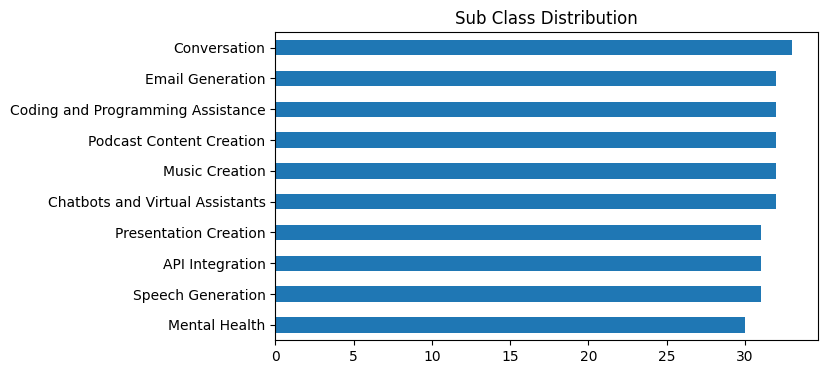

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
df["sub_class"].value_counts(ascending=True).plot.barh()
plt.title("Sub Class Distribution")
plt.show()

#### Encoding the labels

In [5]:
target_map = {}
subclasses = list(df["sub_class"].unique())
for i, subclass in enumerate(subclasses):
    target_map[subclass] = i
target_map

{'Chatbots and Virtual Assistants': 0,
 'Conversation': 1,
 'Mental Health': 2,
 'Music Creation': 3,
 'Speech Generation': 4,
 'Podcast Content Creation': 5,
 'Coding and Programming Assistance': 6,
 'API Integration': 7,
 'Presentation Creation': 8,
 'Email Generation': 9}

In [6]:
df["label"] = df["sub_class"].map(target_map)
df = df[["prompt", "label"]]


df.head()

,prompt,label
0,How can I integrate a chatbot into my website ...,0
1,What are the best practices for designing a co...,0
2,"Can chatbots handle complex queries, or are th...",0
3,What platforms are available for building cust...,0
4,How do I ensure my chatbot understands user in...,0


In [7]:
df.to_csv("../data/interim/subclass_data_labelled.csv", index=False)

### 2 - Splitting the data

In [8]:
from datasets import load_dataset

raw_dataset = load_dataset(
    "csv", data_files="../data/interim/subclass_data_labelled.csv"
)

d:\Softwares\anaconda\envs\llm-data-analyst\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 316 examples [00:00, 11901.41 examples/s]


In [9]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 316
    })
})

In [10]:
split = raw_dataset["train"].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['prompt', 'label'],
        num_rows: 221
    })
    test: Dataset({
        features: ['prompt', 'label'],
        num_rows: 95
    })
})

### 3 - Tokenization

#### Loading the tokenizer

In [11]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
tokenizer("Hello world")

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

#### Tokenizing the data

In [13]:
def tokenize_fn(batch):
    return tokenizer(batch["prompt"], truncation=True)

In [14]:
tokenized_dataset = split.map(tokenize_fn, batched=True)

Map: 100%|██████████| 95/95 [00:00<00:00, 685.17 examples/s]


### 4 - Fine-tuning a pretrained model

#### Loading the model from transformers

In [15]:
from transformers import AutoModelForSequenceClassification

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Model Summary

In [17]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

#### Compiling the model

In [18]:
from transformers import Trainer, TrainingArguments

In [19]:
training_args = TrainingArguments(
    output_dir="../models/subclass_models_v1",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

#### Defining the evaluation metrics

In [20]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="micro")
    return {"accuracy": acc, "f1_score": f1}

#### Training the model

In [21]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

                                               
 25%|██▌       | 14/56 [00:46<02:04,  2.96s/it]

{'eval_loss': 1.9004114866256714, 'eval_accuracy': 0.4105263157894737, 'eval_f1_score': 0.4105263157894737, 'eval_runtime': 3.943, 'eval_samples_per_second': 24.093, 'eval_steps_per_second': 0.507, 'epoch': 1.0}


                                               
 50%|█████     | 28/56 [01:40<01:32,  3.30s/it]

{'eval_loss': 1.606600046157837, 'eval_accuracy': 0.6947368421052632, 'eval_f1_score': 0.6947368421052632, 'eval_runtime': 5.2932, 'eval_samples_per_second': 17.947, 'eval_steps_per_second': 0.378, 'epoch': 2.0}


                                               
 75%|███████▌  | 42/56 [02:34<00:51,  3.69s/it]

{'eval_loss': 1.3214375972747803, 'eval_accuracy': 0.8421052631578947, 'eval_f1_score': 0.8421052631578947, 'eval_runtime': 3.7693, 'eval_samples_per_second': 25.204, 'eval_steps_per_second': 0.531, 'epoch': 3.0}


                                               
100%|██████████| 56/56 [03:29<00:00,  3.07s/it]

{'eval_loss': 1.172629952430725, 'eval_accuracy': 0.9157894736842105, 'eval_f1_score': 0.9157894736842105, 'eval_runtime': 4.0031, 'eval_samples_per_second': 23.731, 'eval_steps_per_second': 0.5, 'epoch': 4.0}


100%|██████████| 56/56 [03:32<00:00,  3.79s/it]

{'train_runtime': 212.1123, 'train_samples_per_second': 4.168, 'train_steps_per_second': 0.264, 'train_loss': 1.7076399666922433, 'epoch': 4.0}


TrainOutput(global_step=56, training_loss=1.7076399666922433, metrics={'train_runtime': 212.1123, 'train_samples_per_second': 4.168, 'train_steps_per_second': 0.264, 'total_flos': 8381614110828.0, 'train_loss': 1.7076399666922433, 'epoch': 4.0})

### 5 - Evaluating the model

#### Loading the best performed model

In [23]:
from transformers import pipeline

In [46]:
saved_model = pipeline(
    "text-classification", model="../models/sub_class_models_v1/checkpoint-84"
)

#### Making predictions on the test data

In [47]:
train_predictions = saved_model(split["train"]["prompt"])
test_predictions = saved_model(split["test"]["prompt"])

In [48]:
test_predictions[:5]

[{'label': 'LABEL_2', 'score': 0.6882415413856506},
 {'label': 'LABEL_4', 'score': 0.8529587388038635},
 {'label': 'LABEL_6', 'score': 0.4961791932582855},
 {'label': 'LABEL_6', 'score': 0.5078295469284058},
 {'label': 'LABEL_1', 'score': 0.7283452153205872}]

#### Evaluation Metrics

In [49]:
def get_label(d):
    return int(d["label"].split("_")[1])


train_prediction_labels = [get_label(d) for d in train_predictions]
test_prediction_labels = [get_label(d) for d in test_predictions]

In [50]:
print(
    "Train Accuracy:", accuracy_score(split["train"]["label"], train_prediction_labels)
)
print("Test Accuracy:", accuracy_score(split["test"]["label"], test_prediction_labels))

Train Accuracy: 0.995475113122172
Test Accuracy: 0.9894736842105263


In [62]:
print(
    "Train F1 Score:",
    f1_score(split["train"]["label"], train_prediction_labels, average="macro"),
)

print(
    "Test F1 Score:",
    f1_score(split["test"]["label"], test_prediction_labels, average="macro"),
)

Train F1 Score: 0.9951219512195122
Test F1 Score: 0.9908902691511386


#### Confusion Matrix

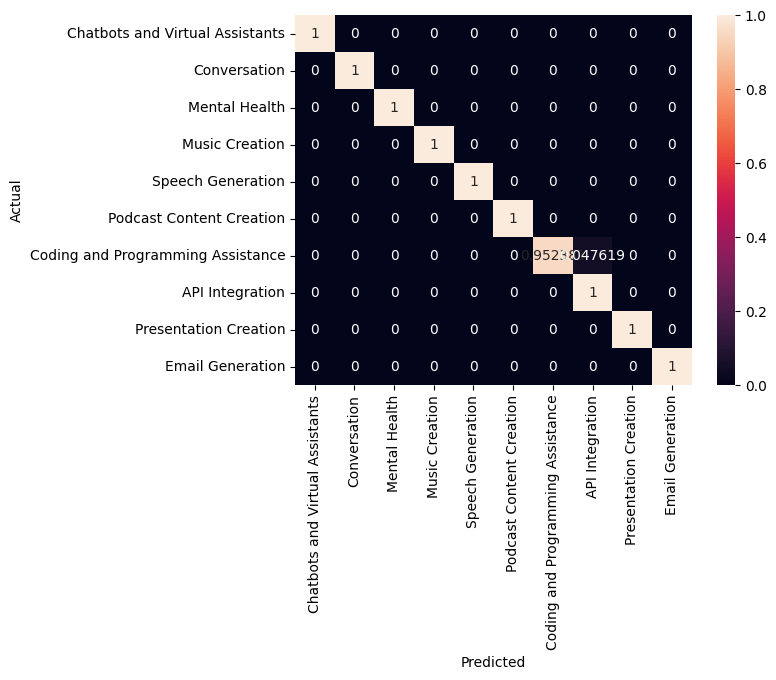

In [53]:
# create function for plotting confusion matrix
def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")


cm = confusion_matrix(
    split["train"]["label"], train_prediction_labels, normalize="true"
)
plot_cm(cm)

#### Custom prompts

In [54]:
def predict(text):
    prediction = saved_model(text)
    if prediction[0]["score"] < 0.6:
        return "General Model"
    label = get_label(prediction[0])
    cluster = list(target_map.keys())[label]
    return cluster

In [55]:
predict("Help me automate digital marketing tasks.")

'General Model'

In [56]:
predict("How do I structure my research paper?")

'General Model'

In [57]:
predict("Help me write a speech on Virat Kohli")

'Speech Generation'

In [58]:
predict("Write a mail to the client asking for a meeting.")

'Email Generation'

In [59]:
predict("How to write a code for linear regression?")

'General Model'

In [60]:
prediction = saved_model("How to write a code for linear regression.")

In [61]:
prediction

[{'label': 'LABEL_6', 'score': 0.26413753628730774}]